# EDA of the demographic and clinical data in the OASIS-1 dataset 

## Goal of the EDA 
The overall goal of this EDA is to get some first insights in to the numeric and image data in the OASIS-1 dataset (https://www.oasis-brains.org). This dataset consists of 416 subjects with 434 MR sessions in total. In the first part of the EDA the demographic, clinical information and anatomic volumes will be visualized with the clinical dementia rating (CDR) to find out if there is a correlation between any of those parameters and risk of getting Alzheimer (CDR > 0). In the second part, the image dataset will be analyzed. 

## The dataset 
The dataset consists of MRI images and numerical data for 416 subjects, of which 316 were diagnosed as being non-demented (CDR = 0, control group) and 100 with being demented ranging from very mild dementia (0.5), mild dementia (1) to moderate dementia (2). The gender is male and female, the age range from 18 to 96. All subjects are right handed. 

### Column description 

- ID - Patient ID 
- M/F - gender, male or female 
- Hand - right handed 
- Educ - education code, 1: less than highschool, 2: high school grad, 3: some college, 4: college grad, 5: beyond college 
- SES - socioeconomic status, categories from 1 (highest status) to 5 (lowest status)
- MMSE - ranges from 0 to 30 (best)
- CDR - clinical dementia rating, 0 = no dementia, 0.5 = very mild, 1 = mild, 2 = moderate dementia 
- eTIV - estimated total intracranial volume ($mm^3$)
- nWBV - percent of all voxels in the atlas-masked image that are labeled as white or gray matter
- ASF - atlas scaling factor, computed scaling factor, that transform native-space brain ad skull to atlas target 
- Delay - images from subsequent scan session (less than 90 days later)

## 1st part - Hypotheses 
1. The risk of having mild or moderate dementia increases with age 
2. There is a correlation of the education level with the dementia stage
3. The MMSE rate correlates with the dementia stage
4. The normalized whole brain volume (nWBV) is inversely correlated with the CDR (smaller volume, higher risk for Alzheimer's)
5. The nWBV decreases with age and educational status 

## 2nd part - Hypotheses 
1. The images all have similar dimensions 
2. All images are readable 
3. The amount of images per class is imbalanced 
4. Each class can be described with two main components. 








## Part 1 - Load required packages and dataset 

In [1]:
#Import packages for data analysis and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#set a colorcode for all the plots 
sns.set_palette(palette='ch:start=.2,rot=-.3')

In [2]:
#Find out the name of the see color to assign it to the plots with only one category
pal=sns.color_palette('ch:start=.2,rot=-.3')
pal.as_hex()[0]

'#c3e2e3'

In [3]:
#Import the dataset

df=pd.read_csv('/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/Data/Tables/oasis_cross-sectional.csv')
df.head(2)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN


### Part 1 - General investigation of the dataset

In [4]:
#Check out what kind of data we have and how many non-null values 
print(df.shape)
df.info()

(436, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


We can see that in our Education column (Educ), Socioeconomic status (SES), MMSE and CDR there is almost half of the data missing. Also in the delay column there are only 20 non-null values. Because of this we will completely drop the delay column. We will also drop the hand column since all or subjects are right-handed and thus this column does not have any further information.
For CDR the NaN values correspond to patients with non dementia and can just be replaced with 0. For the MMSE we can fill in the mean values for the non dementia people. 
In the publication from Marcus et al. (https://pubmed.ncbi.nlm.nih.gov/17714011/, DOI: 10.1162/jocn.2007.19.9.1498), it is described, that only the individuals older than 60 assessed the full Alzheimer Disease Research Center (ADRC) full clinical test which might be the reason why we have missing values for the younger patients. For this reason, we will drop the rows with the missing values and only use the remaining table for our EDA. 


In [5]:
#Get the statistical values for the dataset 
df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


Before we start preprocessing the data we will have some basic investigation of the original dataset.

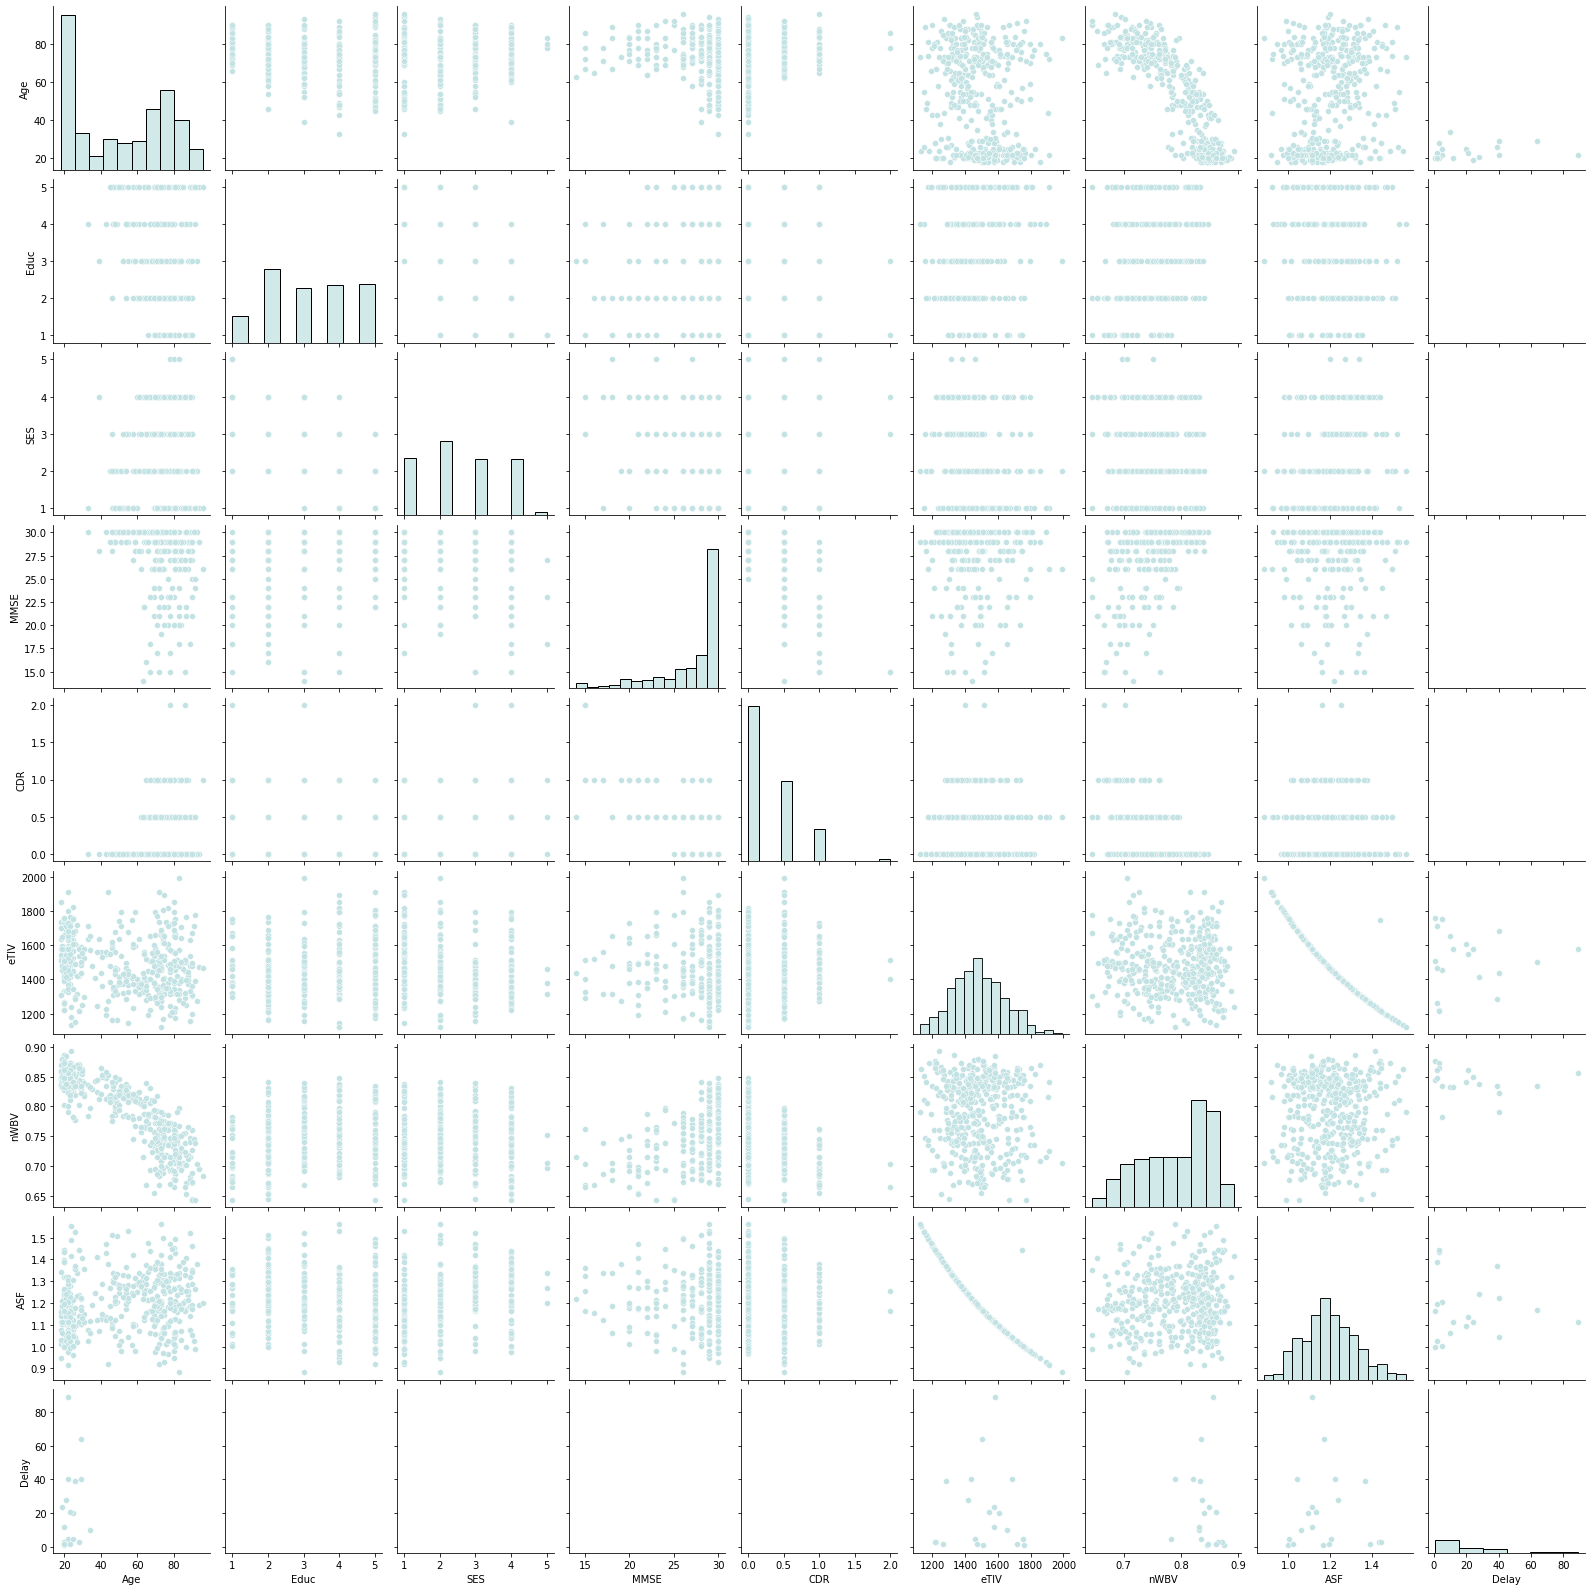

In [6]:
#Create a pairplot to visualize all the potential correlations in the dataset 
sns.pairplot(df);

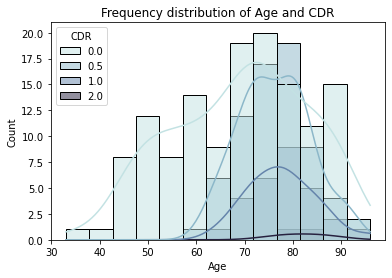

In [7]:
#Create a histogram that shows the distribution of Age and CDR in our dataset 
sns.histplot(data=df, x='Age', hue='CDR',kde=True, palette='ch:start=.2,rot=-.3').set(xlabel='Age', ylabel='Count')
plt.title('Frequency distribution of Age and CDR');


This graph shows that because we have many null values in our low age category, this one could not be displayed here. In general, people younger than 60 only show very mild (CDR = 0.5) dementia, whereas the number of people having very mild dementia ore even more dramatic is increasing after that. 
In the next section we will remove the rows with the missing values and drop some columns that do not contain any information for us. 

### Part 1.1 Preprocessing of the dataset 

In [8]:
#drop the Delay column 
df.drop(labels=['Delay', 'Hand'], axis=1, inplace=True)

#drop the NaN values 
df.dropna(axis=0, inplace=True)

In [9]:
#check how many entries we have left and if there is the same amount of entries for all the columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 415
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      216 non-null    object 
 1   M/F     216 non-null    object 
 2   Age     216 non-null    int64  
 3   Educ    216 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    216 non-null    float64
 6   CDR     216 non-null    float64
 7   eTIV    216 non-null    int64  
 8   nWBV    216 non-null    float64
 9   ASF     216 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 18.6+ KB


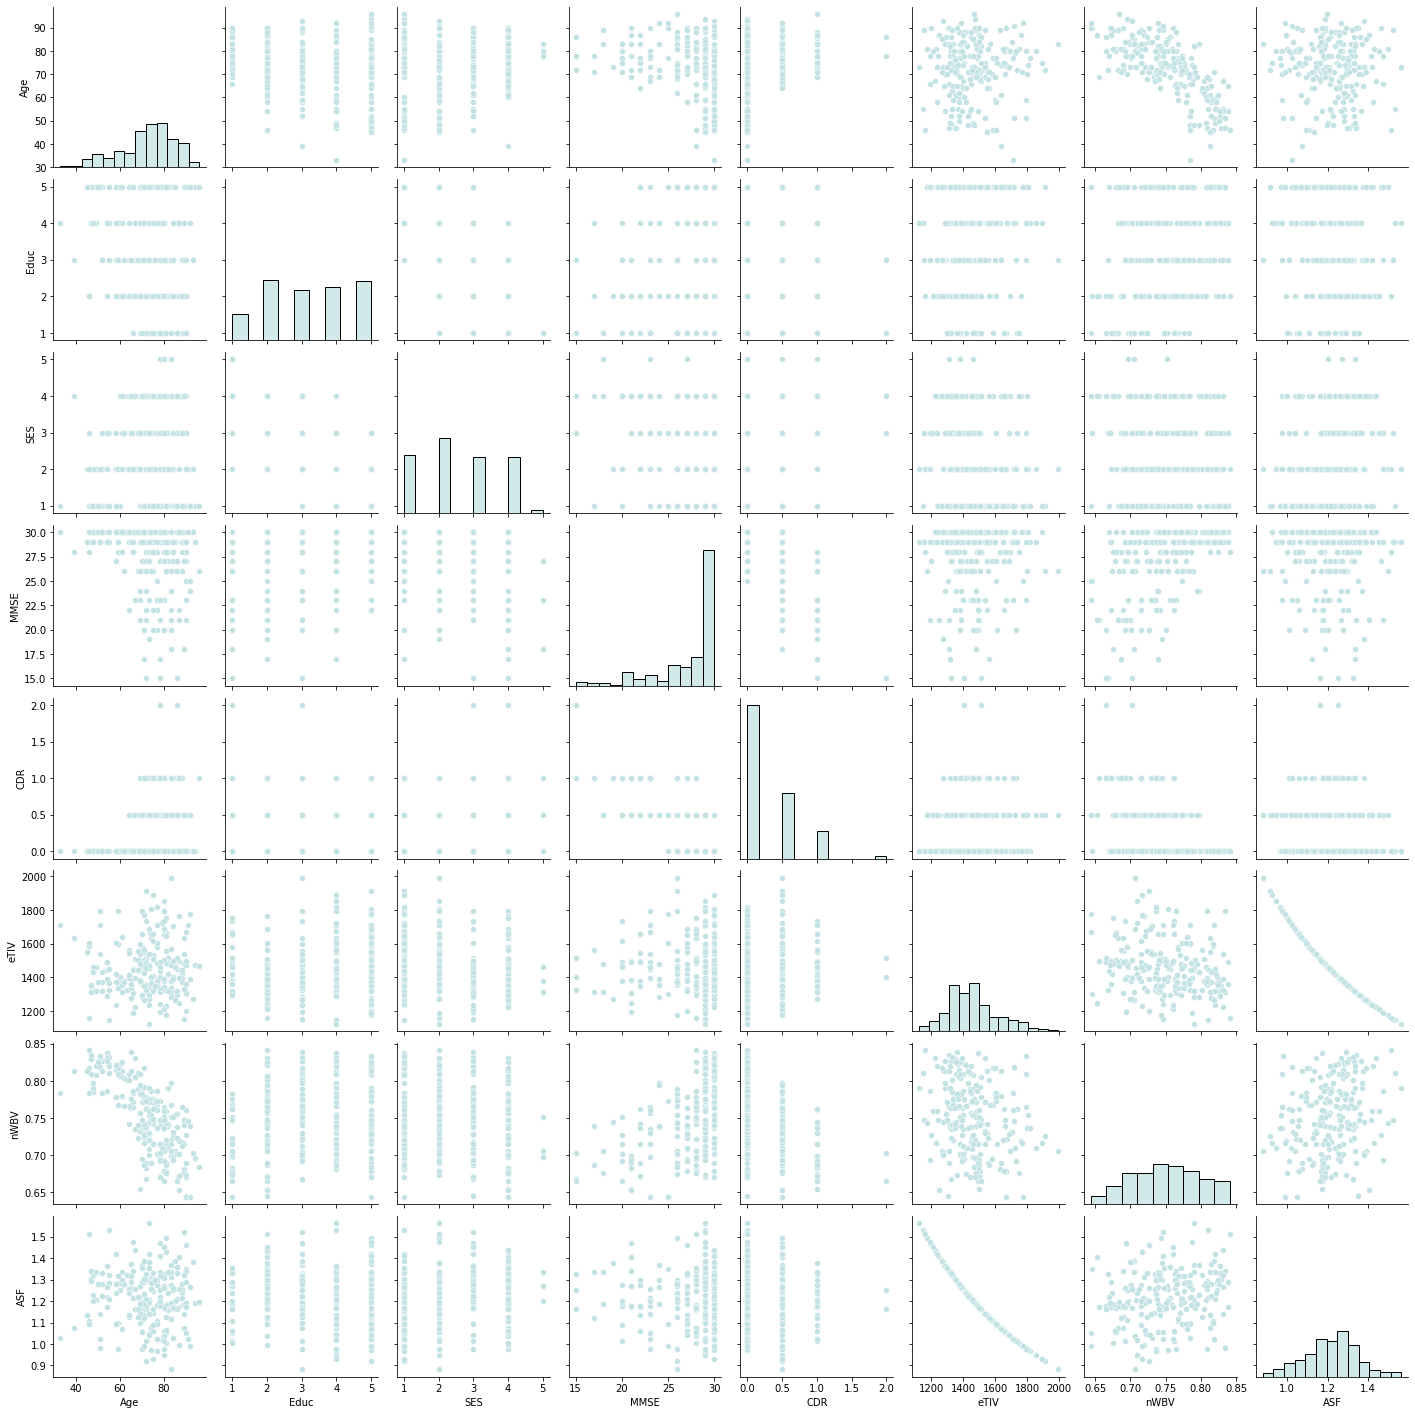

In [10]:
#Create a pairplot to visualize all the potential correlations in the dataset 
sns.pairplot(df);

This pairplot allows us to already see some patterns and distributions in the dataset. For example we can see that for the age category most of the people are older than 60, so the distribution of the age is shifted to the right, meaning the higher ages. For the age, we can also see that there is an inverse correlation of the Age with the brain volume (nWBV), meaning the brain volume decreases with age. For the MMSE distribution we see that most of the people achieved quite good results in the test, with the distribution being shifted to the right. We further see a trend of a correlation of the brain volume with the intracranial volume (eTIV). 

### Part 1 - Visualizations and analysis of the hypotheses 

In the following part the data in the dataframe will be visualized to analyze if there are patterns or correlations in the dataset. The assumptions made at the beginning of the notebook will be analyzed and answered. 

#### Hypothesis 1: The risk of having mild or moderate dementia increases with age 


In [11]:
#Plot showing the dementia cases per gender and age 
#create age bins first 
#since the risk of getting Alzheimer's increases in the high age, we only create two age bins with one until 65 and the other one above 
df_2 = pd.cut(df.Age, bins = 2, labels=['33-65', '65-96'])

#add age categories as a new column to the dataframe 
df=df.join(df_2, how='inner', rsuffix='_category')
df.head(2)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Age_category
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,65-96
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,33-65


In [12]:
#For nicer visualization we also want to have the CDR not as numbers but as 'no', 'very mild', 'mild' and 'moderate 
#define a function to replace the numerical values with categorical values 
def dement_cat(df, feature):
    df[feature] = df[feature].replace(0, 'no')
    df[feature] = df[feature].replace(0.5, 'very mild')
    df[feature] = df[feature].replace(1, 'mild')
    df[feature] = df[feature].replace(2, 'moderate')
    return df

col_pass = ['CDR']

for col in col_pass: 
    df = dement_cat(df, col)

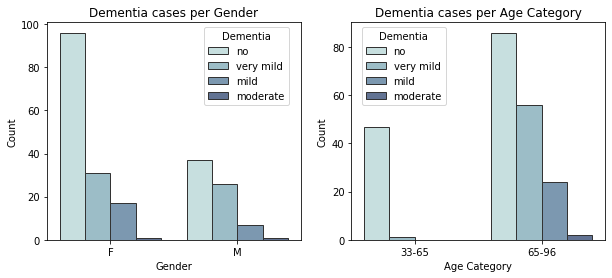

In [13]:
#Create the plot for dementia for age and gender 
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].set_title('Dementia cases per Gender')
sns.countplot(data=df, x='M/F', hue='CDR', ax=axes[0], edgecolor=".2").set(xlabel='Gender', ylabel='Count')
axes[0].legend(title='Dementia',bbox_to_anchor=(0.6, 1), loc='upper left')

sns.countplot(data=df, x='Age_category', hue='CDR', ax=axes[1], edgecolor=".2").set(xlabel='Age Category', ylabel='Count')
axes[1].set_title('Dementia cases per Age Category')
axes[1].legend(title='Dementia',bbox_to_anchor=(0.02, 1), loc='upper left');

In [14]:
#Rename the M/F column to Gender and produce new dataframes for males and females 
df.rename({'M/F': 'Gender'}, axis=1, inplace=True)
df_male = df.query('Gender =="M"').groupby(['CDR']).CDR.count().sort_values(ascending=False)
df_female = df.query('Gender=="F"').groupby(['CDR']).CDR.count().sort_values(ascending=False)



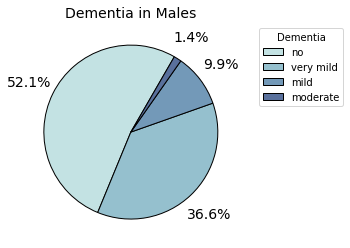

In [15]:
#Pie chart to see percentage of cases per Males 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_male.plot(kind='pie', y='Gender', autopct='%.1f%%', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops, startangle=60).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.5,0.8), loc='right')
plt.title('Dementia in Males', fontsize=14, loc='center');

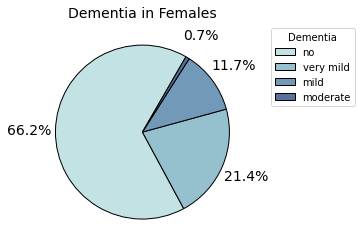

In [16]:
#Pie chart to see percentage of cases per Males 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_female.plot(kind='pie', y='Gender', autopct='%.1f%%', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops, startangle=60).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.5,0.8), loc='right')
plt.title('Dementia in Females', fontsize=14, loc='center');

These two plots show that there are more dementia cases in males than in females (non-demented males=52%, non-demented females=66%). The percentage of males having mild dementia is 37% and 21% for females. Thus, we can conclude that the risk of getting dementia is higher for males than for females.

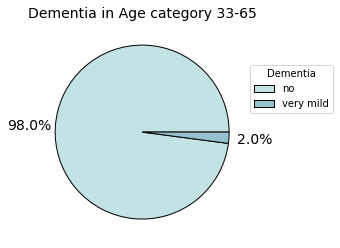

In [17]:
#Create pie charts to see the percentages of cases and not only count 
#create two new dataframes with young and old age category 
df_young = df.query('Age_category=="33-65"').groupby(['CDR']).CDR.count()
df_old = df.query('Age_category=="65-96"').groupby(['CDR']).CDR.count().sort_values(ascending=False)

#Have a pie chart for young age category 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_young.plot(kind='pie', y='CDR', autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0.2 else '', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.4,0.7), loc='right')
plt.title('Dementia in Age category 33-65', fontsize=14, loc='center');



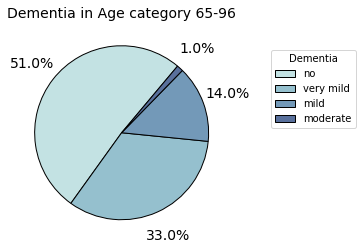

In [18]:
#Have a pie chart for old age category 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot 
df_old.plot(kind='pie', y='CDR', autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0.2 else '', labeldistance=None, pctdistance=1.3, textprops=textprops, startangle=50, wedgeprops=wedgeprops).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.6,0.7), loc='right')
plt.title('Dementia in Age category 65-96', fontsize=14, loc='center');

For the first hypothesis we can conclude from these graphs that the risk of getting Alzheimer's is increasing with age since we have only 2% of cases with very mild dementia in the age category 33-65 but 33% of cases with very mild dementia and 14% with mild dementia in the age class 65-96. However, in both age classes the amount of patients with no dementia is the highest (98% for young age category and 51% for the older ones).

#### Hypothesis 2: There is a correlation of the education level with the dementia stage 

To check this assumption we will create a plot for the education level and the dementia stage. 

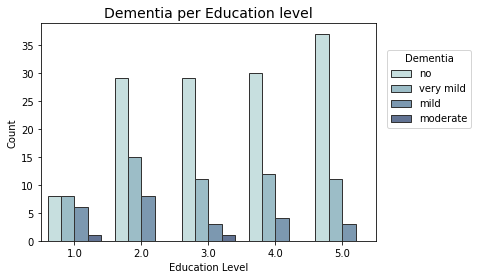

In [19]:
#Plot the education level with the dementia stages
sns.countplot(data=df, x='Educ', hue='CDR', edgecolor=".2").set(xlabel='Education Level', ylabel='Count')
plt.legend(title='Dementia', bbox_to_anchor=(1.3,0.7), loc='right')
plt.title('Dementia per Education level', fontsize=14);

One other way to plot this is to calculate the ratio of the non demented to demented cases in the different education levels. 

In [20]:
#We create a new dataframe with the entries grouped by the Alzheimer stage 
df_pivot=pd.pivot_table(df, index=['Educ', 'CDR'], values='ID',aggfunc='count').reset_index()
df_pivot

,Educ,CDR,ID
0,1.0,mild,6
1,1.0,moderate,1
2,1.0,no,8
3,1.0,very mild,8
4,2.0,mild,8
5,2.0,no,29
6,2.0,very mild,15
7,3.0,mild,3
8,3.0,moderate,1
9,3.0,no,29


In [21]:
#count the non demented cases per education level 

import itertools

totals=[]
def count_totals(df, totals):
    '''Counts all the non-demented cases for the different education levels
    returns a list with the non-demented times three, to apply it to the remaining three dementia stages'''
    totals.append(df[(df['CDR']== "no")&(df['Educ']==1)].ID.count())
    totals.append(df[(df['CDR']== "no")&(df['Educ']==2)].ID.count())
    totals.append(df[(df['CDR']== "no")&(df['Educ']==3)].ID.count())
    totals.append(df[(df['CDR']== "no")&(df['Educ']==4)].ID.count())
    totals.append(df[(df['CDR']== "no")&(df['Educ']==5)].ID.count())

count_totals(df, totals)
totals


[8, 29, 29, 30, 37]

In [22]:
#Remove the entries with no from pivot since we want to normalize to them 
df_pivot.drop(index=[2,5,9,12,15], axis=0, inplace=True)

In [23]:
#Adjust the totals list in such a way that it can be applied to the pivot table 
totals=[8,8,8,29,29,29,29,29,30,30,37,37]
len(totals)

#Calculate the ratio to the non-demented cases stored in the totals list 
df_pivot['ratio']=df_pivot['ID']/totals


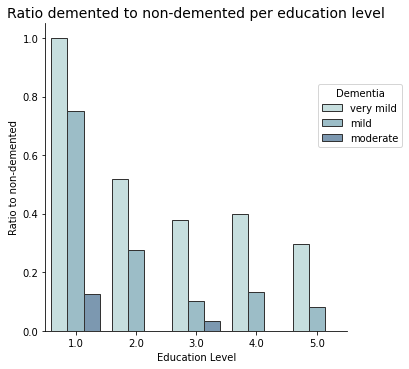

In [24]:
#Plot the ratio of demented to non-demented individuals with the education levels
hue_order=['very mild', 'mild', 'moderate'] 
sns.catplot(data=df_pivot, kind='bar', x='Educ', y='ratio', hue='CDR', hue_order=hue_order, edgecolor=".2", legend=None).set(xlabel='Education Level', ylabel='Ratio to non-demented')
plt.legend(title='Dementia', bbox_to_anchor=(1.2,0.7), loc='right')
plt.title('Ratio demented to non-demented per education level', fontsize=14);

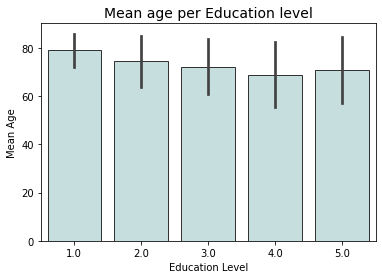

In [25]:
#Plot the mean age per education level to see if there are any differences 
sns.barplot(data=df, x='Educ', y='Age', ci='sd', color='#c3e2e3', edgecolor=".2").set(xlabel='Education Level', ylabel='Mean Age')
plt.title('Mean age per Education level', fontsize=14);

In this plot we can see that in the lowest education category the distribution of dementia cases is quite uniform, meaning we have a similar number of people with no dementia, very mild dementia and mild dementia. For the other levels the amount of people with no dementia is always higher compared to the other stages. For the education level 2, the number of very mild and mild cases is slightly higher than in the other categories. This plot indicates that in the two lowest education levels the changes to get Alzheimer's are slightly higher which might correlate with the slightly higher mean age for these two categories.  

#### Hypothesis 3: The MMSE rate correlates with the dementia stage 

The MMSE is a cognitive test consisting of 11 questions. We assume that there is correlation of the mean points a person gets in the test (30 is the max number of points) and the dementia stage.

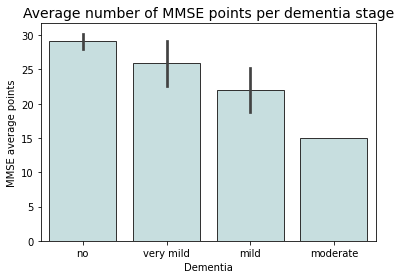

In [26]:
#Plot the average number of points per dementia stage 
sns.barplot(data=df, x='CDR', y='MMSE', color='#c3e2e3', ci='sd', edgecolor=".2").set(xlabel='Dementia', ylabel='MMSE average points')
plt.title('Average number of MMSE points per dementia stage', fontsize=14);

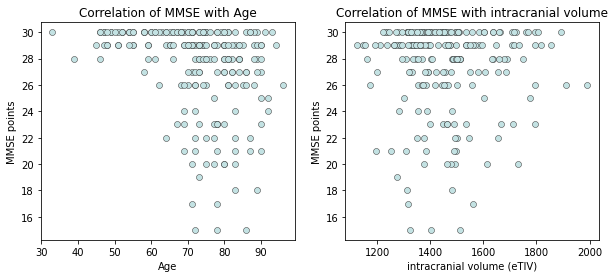

In [27]:
#Let us check if the number of MMSE points also correlates with the age and brain volume and intracranial volume 
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].set_title('Correlation of MMSE with Age')
sns.scatterplot(data=df, x='Age', y='MMSE', ax=axes[0], edgecolor=".2").set(xlabel='Age', ylabel='MMSE points')

axes[1].set_title('Correlation of MMSE with intracranial volume')
sns.scatterplot(data=df, x='eTIV', y='MMSE', ax=axes[1], edgecolor=".2").set(xlabel='intracranial volume (eTIV)', ylabel='MMSE points');


For the third hypothesis we can conclude based on the plot that there is indeed a correlation of the MMSE rate and the stage of dementia. For the non demented individuals, the average number of points achieved is close to the maximum number possible, whereas for the moderate stage the patients achieved less than 15 points. 

#### Hypothesis 4: The normalized whole brain volume (nWBV) is inversely correlated with the CDR

This would mean that the lower the brain volume the worse the dementia stage. 

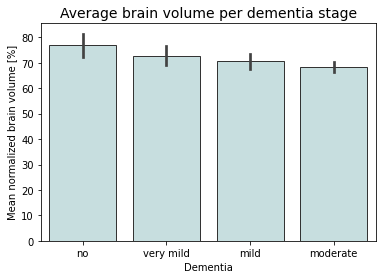

In [28]:
#Plot the normalized brain volume with the dementia stage
#Since the normalized brain volume is given in percentage we first need to multiply all the entries with 100 to get the actual percentage value 
df['Brain_volume'] = df['nWBV']*100

sns.barplot(data=df, x='CDR', y='Brain_volume', color='#c3e2e3', ci='sd', edgecolor=".2").set(xlabel='Dementia', ylabel='Mean normalized brain volume [%]')
plt.title('Average brain volume per dementia stage', fontsize=14);

From this plot we can conclude for our assumption that there is only a slight correlation with the mean brain volume and the dementia stage. 

#### Hypothesis 5: The nWBV decreases with age and educational status 

For this we first plot the brain volume (nWBV) with the age and create a second plot which also includes the educational status. 

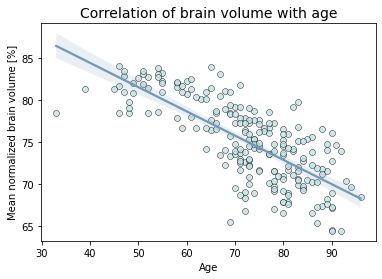

In [29]:
#Plot the brain volume with the age 
sns.regplot(data=df, x='Age', y='Brain_volume', x_ci='sd', scatter_kws={'linewidths':.5,'edgecolor':'k'}, line_kws={'color':'#7399b8'}).set(xlabel='Age', ylabel='Mean normalized brain volume [%]')
plt.title('Correlation of brain volume with age', fontsize=14);

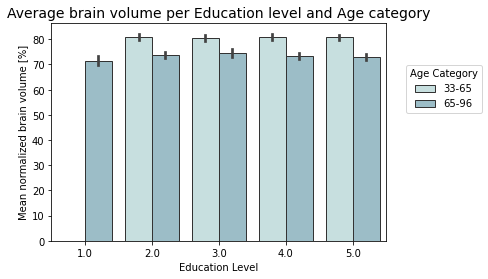

In [30]:
#Plot the brain volume with Age and educational status 
sns.barplot(data=df, x='Educ', y='Brain_volume', hue='Age_category', edgecolor=".2").set(xlabel='Education Level',ylabel='Mean normalized brain volume [%]')
plt.legend(title='Age Category', bbox_to_anchor=(1.3,0.7), loc='right')
plt.title('Average brain volume per Education level and Age category', fontsize=14);

From both plots we can see that there is a linear correlation between the brain volume and the age, which means that the brain volume decreases with age. For the Education status we can see that there is no difference in the brain volume, despite it being smaller for the older people. 
